# Sentiment Analysis using Deepgram and Hugging Face

In this notebook, we will be exploring how to analyze sentiment for audio/video clips using the Deepgram API and the **siebert/sentiment-roberta-large-english** model which is available on [Hugging Face](https://huggingface.co/).

Link to the SiEBERT model: https://huggingface.co/siebert/sentiment-roberta-large-english?text=How+are+you+doing+today%3F

For the purpose of this tutorial we will be using the following packages:

- **Dotenv**: The **dotenv** library is used to load environment variables from a `.env` file, which is commonly used to store configuration settings for the application.

- **Transformers**: The **Transformers** library from Hugging Face is utilized for natural language processing (NLP) tasks such as sentiment analysis. The "pipeline" function from this library is used to build a sentiment analysis model.<br>

- **NumPy**: **NumPy** is utilized for numerical computations and array operations. It is used in this code to define weights for each sentiment category and calculate compound scores.<br>

- **Pandas**: **Pandas** is used for data manipulation and analysis. It is used to process and store the sentiment analysis results in a DataFrame format.<br>

- **Deepgram**: The **Deepgram** Python SDK is used to perform speech-to-text transcription. The script sends local audio files or hosted audio file URLs to Deepgram and receives transcriptions in response.

- **Scikit Learn**: Allows us access to mathematical tools like gaussian filters, which will help clean our sentiment results by getting rid of the outliers.


### Download the required packages

In [1]:
!pip install -r requirements.txt

### Importing the required packages

In [2]:
# For computation & machine learning
import numpy as np
import pandas as pd
from scipy.special import softmax
from scipy.ndimage import gaussian_filter1d
from collections import deque
import torch
from transformers import pipeline


# For plotting the results
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# For transcription
from deepgram import Deepgram

#For miscellaneous functionality:
import os
from dotenv import load_dotenv
import datetime


sns.set_theme()

### Loading the environment variables

We will be storing the **DEEPGRAM_API_KEY** in the `.env` file on our computer. For this step, just copy the `.env.sample` file in the repository and replace it with your Deepgram API key. If you do not have one already, go to the next section where we talk about how to get the API key and then come back and run this cell!

In [3]:
load_dotenv()

True

In [4]:
DEEPGRAM_API_KEY = os.getenv("DEEPGRAM_API_KEY")

### Processing Audio

For the purpose of this tutorial, you can use any podcast/youtube video of your choice. While Deepgram supports some video extensions, it would be advisable to download the files in an audio-only format as they are usually smaller and faster to send to the server.

We will be saving all our audio files in the `./data` folder inside the parent directory. You can also use python packages like **ytdl** which will allow you to download youtube videos from this notebook itself.

**Note**: Deepgram can also directly pass audio clips that are hosted on the cloud.

For the purpose of this tutorial, we will be using the Elon Musk BBC interview where he accuses the host of lying. <br>

Interview Link: https://www.youtube.com/watch?v=IflfP4XwzAI&ab_channel=TeslaIntelligenceUK

In [5]:
# Validating that the file is present
os.listdir('./data')

['elon-bbc.mp3']

### Transcribing Audio

Now that we have the audio locally stored, we can start with the first step, which involves converting the audio data to text -- something which our NLP models can understand for sentiment analysis!

The models we are using for the purpose of this tutorial are specially made to work with textual data, as they have been trained on a corpus of statements. Therefore, to convert our audio files into text-based transcripts, we will be using the <a src="https://www.deepgram.com">Deepgram API</a>. 

Deepgram makes it seamless to transcribe audio files. They basically take away the hassle of running our own transcription models by providing us with cloud-hosted models that are more accurate than anything that exists in the market. 

To get started with Deepgram, go to https://console.deepgram.com/signup and create a free account. Every new user gets $200 worth of free transcription credits which are much more than enough for our use case. Once you have created an account, head over to API key section within the Deepgram console and get a new key. We will be needing this to transcribe the audio.

To interact with Deepgram, we will be using the [deepgram-python-sdk](https://github.com/deepgram/deepgram-python-sdk) to make it easier to fetch transcription results from the API without knowing anything about interacting with APIs!

In [17]:
# Reading the audio file & passing it into deepgram
dg = Deepgram(DEEPGRAM_API_KEY)
source = {}
with open('./data/elon-bbc.mp3', 'rb') as audio:
    source = {'buffer': audio, 'mimetype': 'mp3'}
    response = await dg.transcription.prerecorded(source, {'paragraphs': True, 'diarize':True})

In [109]:
# Inspecting the response returned from deepgram!
print(str(response)[0:300])
print('...')
print(str(response)[-300:])

{'metadata': {'transaction_key': 'deprecated', 'request_id': '2a011806-6c30-4819-ba1e-06ec2aab8678', 'sha256': 'c0c48fc685c47b855a522ca68951aec246fef472b13ca8f0616e3acfc771699e', 'created': '2023-08-07T14:48:36.197Z', 'duration': 3426.2217, 'channels': 1, 'models': ['96a295ec-6336-43d5-b1cb-1e48b5e6
...
reat.", 'start': 3419.2231, 'end': 3419.4622, 'speaker': 1}, {'text': "It's way better.", 'start': 3419.7012, 'end': 3420.3386, 'speaker': 1}, {'text': 'Better by a lot.', 'start': 3422.735, 'end': 3423.3735, 'speaker': 1}], 'speaker': 1, 'num_words': 9, 'start': 3419.2231, 'end': 3419.2231}]}}]}]}}


Don't worry too much about the structure of the response; in the next few steps we will extract the actual transcripts out of the json that will then be passed into a custom sentiment analysis function that we will be building.

### Setting up the sentiment analysis pipeline (Machine Learning stuff)!

In this part of the notebook, we will be building our sentiment analysis pipeline. Using Hugging Face, we can actually deploy these models using just one line of code. 

For our use case we will be using the Twitter RoBERTa base model, which expands on the roberta model with a finetune on Twitter data. 

To make the tutorial simple, we will be using the 'pipeline' class from Hugging Face's transformer library. 

Pipelines are an easy way to use models for inference. These pipelines are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks, including Named Entity Recognition, Masked Language Modeling, Sentiment Analysis, Feature Extraction and Question Answering.

In [19]:
pipe = pipeline("text-classification")
pipe("This restaurant is awesome")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998743534088135}]

For sentiment analysis, we will select the **cardiffnlp/twitter-roberta-base-sentiment** model due to its suitability for handling short, informal text typically found on social media platforms, such as Twitter. Because the language on Twitter is so unique - often using abbreviations, emojis, and informal epressions - we are using a model that has been trained on a large corpus of social media content, such as tweets.


In [20]:
sentiment_analysis = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment", top_k=3)

Now that our pipeline is all set, we can start analyzing statements for their sentiment. Note, using the **top_k = 3** method, we can force the sentiment analysis pipeline to return the scores for all the 3 sentiment classifications:<br>
<ul>
    <li>Neutral Statement</li>
    <li>Positive Statement</li>
    <li>Negative Statement</li>
</ul>

In [21]:
sentiment_analysis("My sentiment analysis pipeline is up and running!")

[[{'label': 'LABEL_2', 'score': 0.7614049315452576},
  {'label': 'LABEL_1', 'score': 0.23623278737068176},
  {'label': 'LABEL_0', 'score': 0.002362299244850874}]]

Here `LABEL_1` refers to a neutral statement, `LABEL_2` to a positive statement, and `LABEL_0` refers to a negative statement. The result above showcases that our model is 76.14% confident that the statement is positive, and 23.62% confident that the statement is neutral.
 
To make it simple for us to understand the sentiments, let's write a function which replaces the labels with 'POSITIVE', 'NEGATIVE' and 'NEUTRAL'

In [50]:
def process_sentiment_res(sent):
    res = {}
    for s in sent[0]:
        if s['label'] == 'LABEL_2':
            label = 'POSITIVE'
        elif s['label'] == 'LABEL_0':
            label = 'NEGATIVE'
        else:
            label = 'NEUTRAL'
        res[label] = s['score']
    return res

In [51]:
sent = sentiment_analysis("My sentiment analysis pipeline is up and running!")
process_sentiment_res(sent)

{'POSITIVE': 0.7614049315452576,
 'NEUTRAL': 0.23623278737068176,
 'NEGATIVE': 0.002362299244850874}

Next we will write a function to convert these three probabiltes into a single composite score that can help describe the models' sentiment classification. 

To do this we will assign weights to each category where a NEGATIVE statement is -1, POSITIVE is +1 and NEUTRAL is 0. Using a dot product of the scores and these weights, we will get a composite score between -1 and 1 that shows the models' sentiment classification of the statement where -1 is very negative (confidence) and +1 (confidence) is very positive.

In [113]:
def calculate_compound_score(sent_res):
    sentiment_probabilities = np.array([sent_res['NEGATIVE'],sent_res['NEUTRAL'],sent_res['POSITIVE']])
    weights = np.array([-1, 0, 1], dtype=np.float32)
    return np.dot(sentiment_probabilities,weights)

In [53]:
calculate_compound_score(process_sentiment_res(sent))

0.7590426323004067

This indicates that the model assigns a sentiment score of 0.75 to the statement within a range of -1 to 1, suggesting that the statement leans strongly towards the positive side of the scale. 

Now let's put it all together and build a single function that takes in a statement (string) and returns a compound score.

In [66]:
def analyze_statement(statement):
    sent = sentiment_analysis(statement)
    cleaned_dict = process_sentiment_res(sent)
    return calculate_compound_score(cleaned_dict)

In [67]:
analyze_statement("My sentiment analysis pipeline is up and running!")

0.7590426323004067

In [68]:
analyze_statement("I am having a bad day")

-0.9484810708090663

### Running the sentiment pipeline on our audio data

From our transcription results from Deepgram, we can get the individual paragraphs back by using this line of code:

In [59]:
all_sentences = response['results']['channels'][0]['alternatives'][0]['paragraphs']['paragraphs']

In [112]:
# Printing first 3 sentences
all_sentences[:3]

[{'sentences': [{'text': 'Why why did you agree to do this?',
    'start': 0.5960177,
    'end': 2.4238052,
    'speaker': 0},
   {'text': 'This with the Bbc.',
    'start': 2.6622124,
    'end': 3.8542478,
    'speaker': 0}],
  'speaker': 0,
  'num_words': 12,
  'start': 0.5960177,
  'end': 3.8542478},
 {'sentences': [{'text': "I don't know I like a functioning eighty.",
    'start': 4.966814,
    'end': 6.3972564,
    'speaker': 1},
   {'text': "And I know this look there's lot going on.",
    'start': 7.112478,
    'end': 8.860796,
    'speaker': 1},
   {'text': 'It seems like I actually do have a lot respect with the Bbc.',
    'start': 9.193873,
    'end': 12.375856,
    'speaker': 1},
   {'text': "Well, that's else we get what the Bbc stands for, you know, But where when is to.",
    'start': 14.125946,
    'end': 18.459858,
    'speaker': 1}],
  'speaker': 1,
  'num_words': 47,
  'start': 4.966814,
  'end': 18.459858},
 {'sentences': [{'text': 'You know what it stands for.',
   

To make it easier for us to organize everything in a pandas dataframe we will write some custom code that uses the paragraphs portion of the Deepgram transcript and creates a pandas DataFrame.

In [64]:
result = []
for s in all_sentences:
    speaker_sentences = s['sentences']
    for sentence in speaker_sentences:
        sentence['speaker'] = s['speaker']
        result.append(sentence)
df = pd.DataFrame(result)
df.head()

,text,start,end,speaker
0,Why why did you agree to do this?,0.596018,2.423805,0
1,This with the Bbc.,2.662212,3.854248,0
2,I don't know I like a functioning eighty.,4.966814,6.397256,1
3,And I know this look there's lot going on.,7.112478,8.860796,1
4,It seems like I actually do have a lot respect...,9.193873,12.375856,1


Now let's run the sentiment analysis function we built on this Deepgram transcript! We will also be adding two columns - `start_time` and `end_time` - that use the start and end second timestamps and convert them into an arbitrary datetime object.

In [88]:
df['sentiment'] = df['text'].apply(analyze_statement)
df['start_time'] = df['start'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df['end_time'] = df['end'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df.head()

,text,start,end,speaker,sentiment,start_time,end_time
0,Why why did you agree to do this?,0.596018,2.423805,0,-0.712457,1969-12-31 19:00:00.596018,1969-12-31 19:00:02.423805
1,This with the Bbc.,2.662212,3.854248,0,0.025702,1969-12-31 19:00:02.662212,1969-12-31 19:00:03.854248
2,I don't know I like a functioning eighty.,4.966814,6.397256,1,-0.674057,1969-12-31 19:00:04.966814,1969-12-31 19:00:06.397256
3,And I know this look there's lot going on.,7.112478,8.860796,1,-0.103927,1969-12-31 19:00:07.112478,1969-12-31 19:00:08.860796
4,It seems like I actually do have a lot respect...,9.193873,12.375856,1,0.795092,1969-12-31 19:00:09.193873,1969-12-31 19:00:12.375856


Doing some quick exploratory data analysis, we can get some quick insights into the overall results of the podcast.

In [89]:
df['sentiment'].describe()

count    1193.000000
mean       -0.075867
std         0.382207
min        -0.949922
25%        -0.293465
50%        -0.061290
75%         0.124047
max         0.985015
Name: sentiment, dtype: float64

Looking into the overall summary of the results, it is evident that on the average, the podcast was mostly neutral with an average sentiment score of -0.07

Now that we know the time-wise sentiment of the speakers, we can quickly plot the speaker-wise results to get an idea of how the sentiments changed over time as the podcast progressed.

In [110]:
df.head(10)

,text,start,end,speaker,sentiment,start_time,end_time
0,Why why did you agree to do this?,0.596018,2.423805,0,-0.712457,1969-12-31 19:00:00.596018,1969-12-31 19:00:02.423805
1,This with the Bbc.,2.662212,3.854248,0,0.025702,1969-12-31 19:00:02.662212,1969-12-31 19:00:03.854248
2,I don't know I like a functioning eighty.,4.966814,6.397256,1,-0.674057,1969-12-31 19:00:04.966814,1969-12-31 19:00:06.397256
3,And I know this look there's lot going on.,7.112478,8.860796,1,-0.103927,1969-12-31 19:00:07.112478,1969-12-31 19:00:08.860796
4,It seems like I actually do have a lot respect...,9.193873,12.375856,1,0.795092,1969-12-31 19:00:09.193873,1969-12-31 19:00:12.375856
5,"Well, that's else we get what the Bbc stands f...",14.125946,18.459858,1,-0.150750,1969-12-31 19:00:14.125946,1969-12-31 19:00:18.459858
6,You know what it stands for.,21.156086,22.114952,0,-0.102554,1969-12-31 19:00:21.156086,1969-12-31 19:00:22.114952
7,Yes I do.,23.792973,24.432217,1,0.405245,1969-12-31 19:00:23.792973,1969-12-31 19:00:24.432217
8,So Yeah.,25.790613,27.873417,1,0.394437,1969-12-31 19:00:25.790613,1969-12-31 19:00:27.873417
9,Yeah So there's there's lot going on.,28.032228,29.540941,1,-0.089712,1969-12-31 19:00:28.032228,1969-12-31 19:00:29.540941


Manually looking at the transcripts, we can set up the speaker names, which will help make the sentiment charts a lot easier to understand.

In [91]:
speaker_names = {
    0:'James Clayton (BBC Interviewer)',
    1:'Elon Musk',
}

Now that we have the speakers, let's plot!

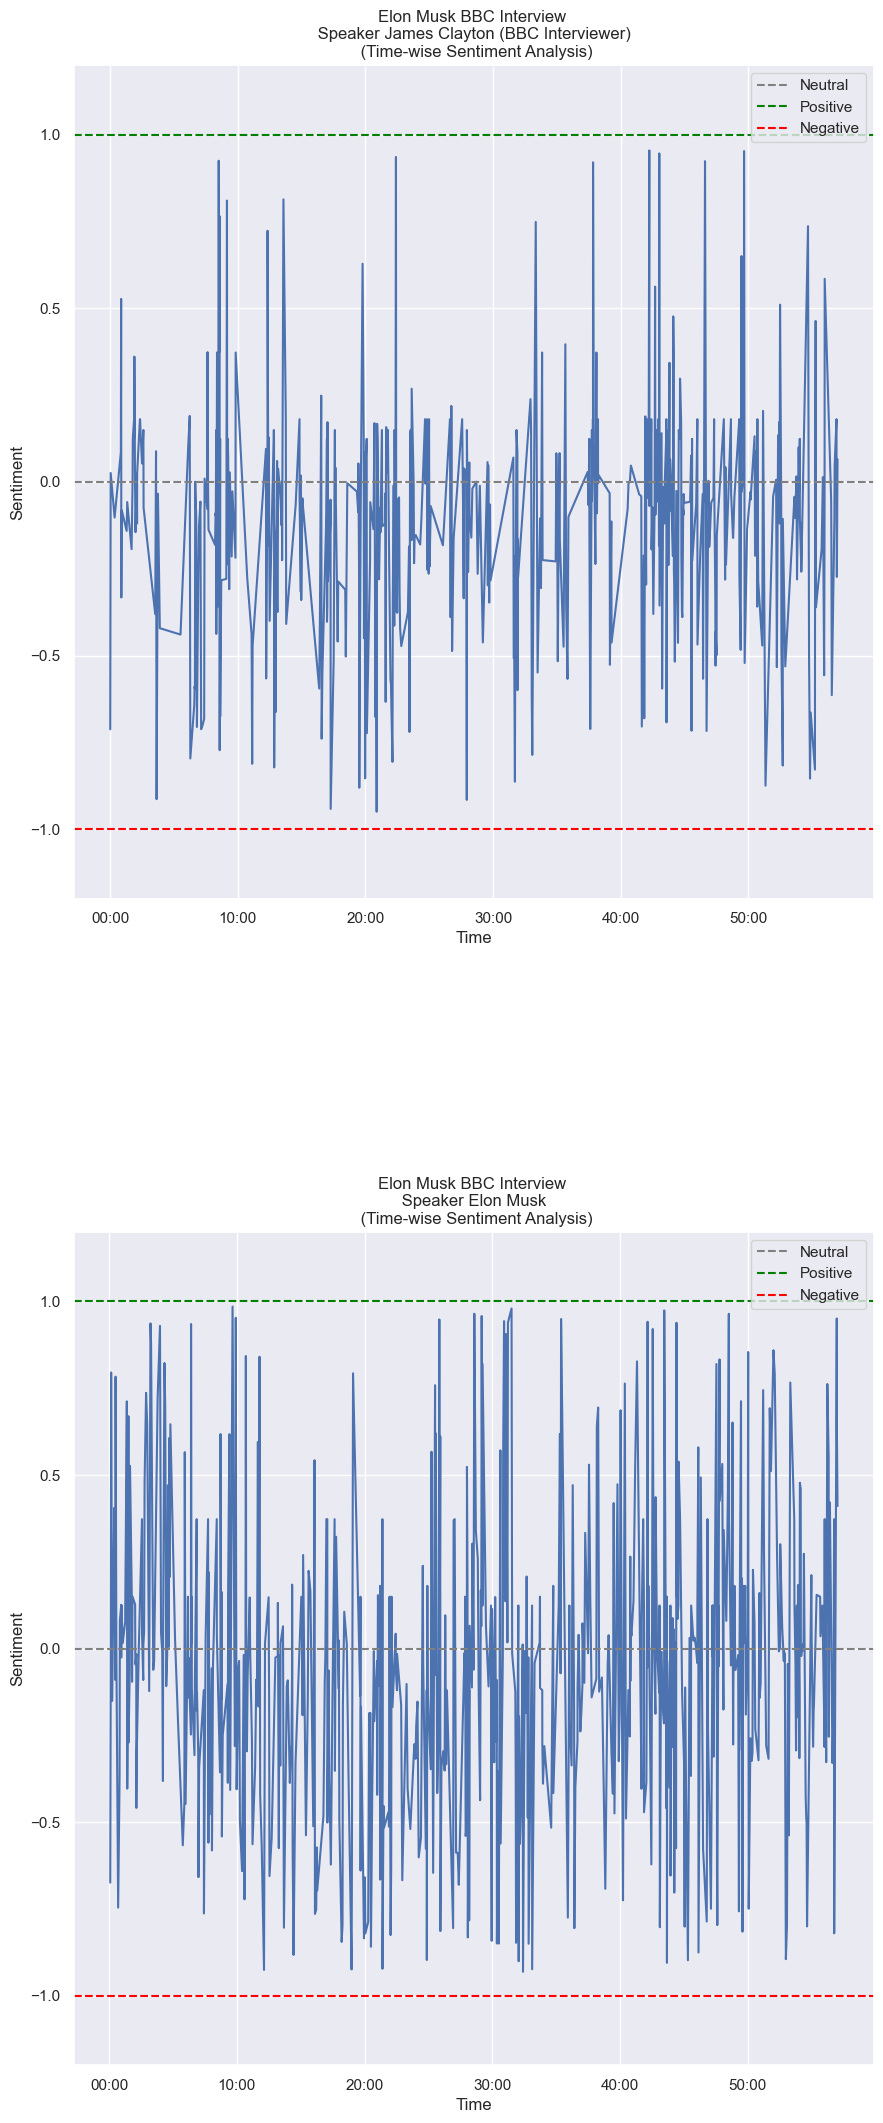

In [100]:
fig, axis = plt.subplots(df['speaker'].max()+1,figsize=(10,20))


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)


for speaker,ax in enumerate(axis):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Sentiment')
    ax.set_title(f'Elon Musk BBC Interview \n Speaker {speaker_names[speaker]} \n (Time-wise Sentiment Analysis)')
    
    datapoints = df[df['speaker']==speaker]
    # Apply Gaussian filter for smoothing
    ax.plot(datapoints['start_time'], datapoints['sentiment'])

    # Add the reference lines
    ax.axhline(0, color='gray', linestyle='--', label='Neutral')
    ax.axhline(1, color='green', linestyle='--', label='Positive')
    ax.axhline(-1, color='red', linestyle='--', label='Negative')

    ax.legend()

plt.show()

The current chart looks all over the place and does not tell much about the speaker's sentiment at that point in time. However, there is a way to extract insights from this. We will essentially be using a technique called smoothing, where we apply a Gaussian filter to smooth the sentiment scores, providing a more continuous representation of the sentiment over time. Smoothing helps eliminate noisy fluctuations in sentiment, making the results more interpretable and visually appealing.

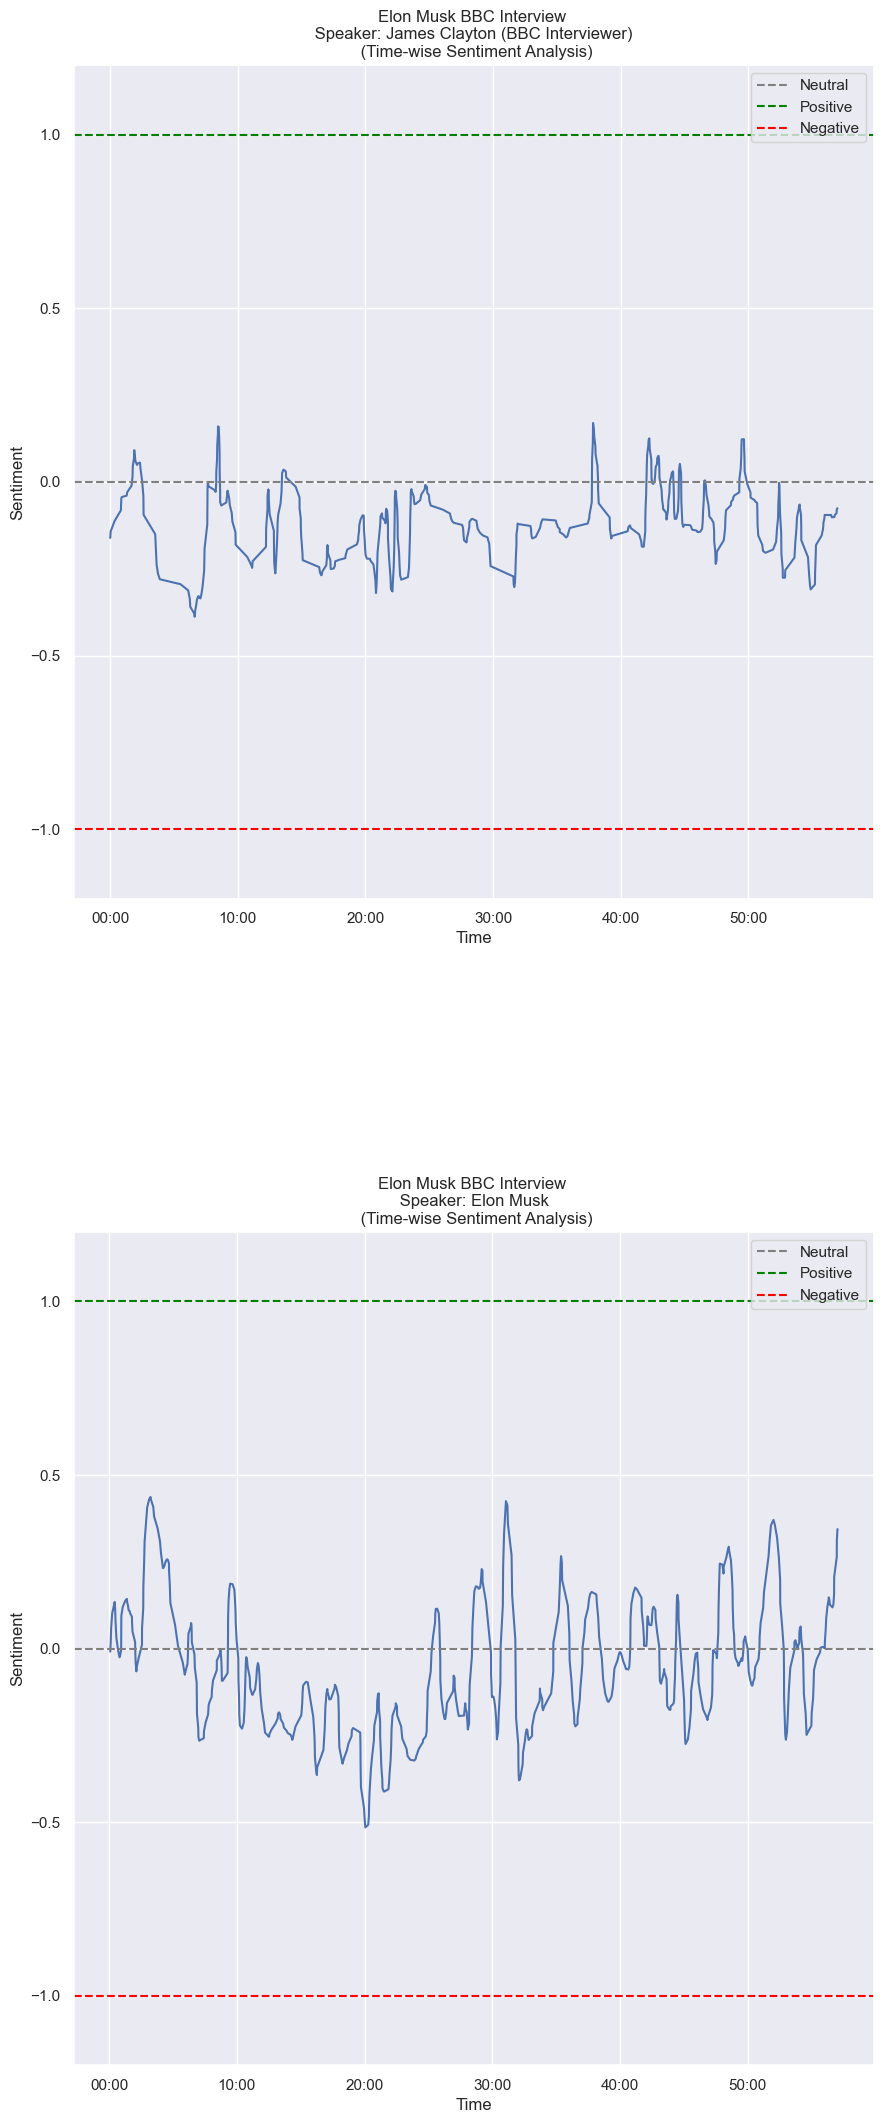

In [101]:
fig, axis = plt.subplots(df['speaker'].max()+1,figsize=(10,20))


# set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0,
                    right=0.9,
                    top=1,
                    wspace=0.4,
                    hspace=0.4)


for speaker,ax in enumerate(axis):
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
    ax.set_ylim(-1.2, 1.2)
    ax.set_xlabel('Time')
    ax.set_ylabel('Sentiment')
    ax.set_title(f'Elon Musk BBC Interview \n Speaker: {speaker_names[speaker]} \n (Time-wise Sentiment Analysis)')
    
    datapoints = df[df['speaker']==speaker]
    
    # Apply Gaussian filter for smoothing
    sigma = 3  # Standard deviation for Gaussian kernel
    smoothed_scores_gaussian = gaussian_filter1d(datapoints['sentiment'], sigma)

    ax.plot(datapoints['start_time'], smoothed_scores_gaussian)

    # Add the reference lines
    ax.axhline(0, color='gray', linestyle='--', label='Neutral')
    ax.axhline(1, color='green', linestyle='--', label='Positive')
    ax.axhline(-1, color='red', linestyle='--', label='Negative')

    ax.legend()

plt.show()

You can tweak the sigma values based on how much smoothing you would want to apply. Based on the charts above, we can see that for a major chunk of the podcast, the interviewer's sentiment was almost always below the 0 line while Elon Musk's statements became evidently negative around the 10 to 30 minute mark. If you have seen the interview, this is the time period when he accuses the BBC interviewer of lying.

This is how you can calculate sentiment and build sentiment charts for any audio/video clip by combining Deepgram's transcription and diarization with a Hugging Face sentiment analysis pipeline.